In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                          download=True, transform=transform_train)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                         download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, 
                                          shuffle=False, num_workers=2)

class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [4]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

        self.dropout = nn.Dropout(dropout_rate)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [5]:
def train_model(model, train_loader, test_loader, epochs=100):
    print(f"Training for {epochs} epochs...\n")  
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data  

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data 

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                
                all_preds.extend(predicted.numpy())
                all_labels.extend(labels.numpy())

        val_acc = 100. * correct / total
        val_loss = val_loss / len(test_loader)

        
        f1 = f1_score(all_labels, all_preds, average='weighted')

        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)

        if val_acc > best_acc:
            best_acc = val_acc

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'F1 Score: {f1:.4f}')
        print(f'Best Acc: {best_acc:.2f}%\n')


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies
        
       

Training for 20 epochs...

Epoch 1/20:
Train Loss: 1.6725 | Train Acc: 37.98%
Val Loss: 1.3087 | Val Acc: 52.00%
F1 Score: 0.5050
Best Acc: 52.00%

Epoch 2/20:
Train Loss: 1.3394 | Train Acc: 51.30%
Val Loss: 1.0693 | Val Acc: 60.90%
F1 Score: 0.6028
Best Acc: 60.90%

Epoch 3/20:
Train Loss: 1.2032 | Train Acc: 56.93%
Val Loss: 1.0256 | Val Acc: 63.63%
F1 Score: 0.6417
Best Acc: 63.63%

Epoch 4/20:
Train Loss: 1.1148 | Train Acc: 60.57%
Val Loss: 0.9372 | Val Acc: 66.30%
F1 Score: 0.6565
Best Acc: 66.30%

Epoch 5/20:
Train Loss: 1.0507 | Train Acc: 63.09%
Val Loss: 0.9036 | Val Acc: 67.82%
F1 Score: 0.6759
Best Acc: 67.82%

Epoch 6/20:
Train Loss: 0.9962 | Train Acc: 65.02%
Val Loss: 0.7990 | Val Acc: 72.03%
F1 Score: 0.7176
Best Acc: 72.03%

Epoch 7/20:
Train Loss: 0.9581 | Train Acc: 66.46%
Val Loss: 0.7432 | Val Acc: 73.24%
F1 Score: 0.7255
Best Acc: 73.24%

Epoch 8/20:
Train Loss: 0.9282 | Train Acc: 67.75%
Val Loss: 0.7491 | Val Acc: 73.60%
F1 Score: 0.7288
Best Acc: 73.60%

Epoch

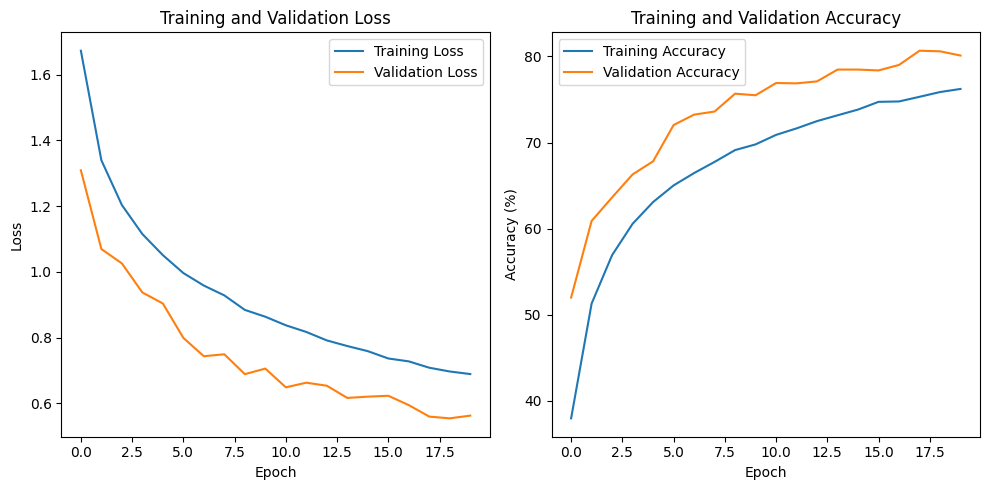

In [7]:
model = CNN()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, epochs=20)